AttributeError: module 'tensorflow' has no attribute 'placeholder'

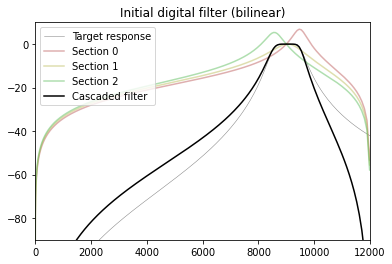

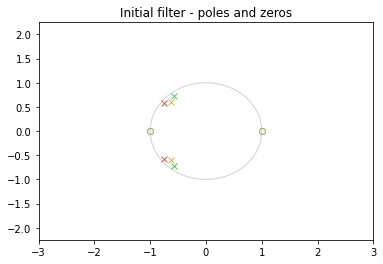

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from scipy import signal

import tensorflow as tf

# Number of sections
M = 3

# Sample rate
f_s = 24000

# Passband center frequency
f0 = 9000

# Number of frequencies to compute
N = 2048

section_colors = np.zeros([M, 3])
for k in range(M):
    section_colors[k] = clr.hsv_to_rgb([(k / (M - 1.0)) / 3.0, 0.5, 0.75])

# Get one of BP poles that maps to LP prototype pole.
def lp_to_bp(s, rbw, w0):
    return w0 * (s * rbw / 2 + 1j * np.sqrt(1.0 - np.power(s * rbw / 2, 2)))

# Frequency response

def freq_response(z, b, a):
    p = b[0]
    q = a[0]
    for k in range(1, len(b)):
        p += b[k] * np.power(z, -k)
    for k in range(1, len(a)):
        q += a[k] * np.power(z, -k)
    return p / q

# Absolute value in decibel

def abs_db(h):
    return 20 * np.log10(np.abs(h))

# Poles of analog low-pass prototype

none, S, none = signal.buttap(M)

# Band limits
c = np.power(2, 1 / 12.0)
f_l = f0 / c
f_u = f0 * c

# Analog frequencies in radians
w0 = 2 * np.pi * f0
w_l = 2 * np.pi * f_l
w_u = 2 * np.pi * f_u

# Relative bandwidth
rbw = (w_u - w_l) / w0

jw0 = 2j * np.pi * f0
z0 = np.exp(jw0 / f_s)

# 1. Analog filter parameters

bc, ac = signal.butter(M, [w_l, w_u], btype='bandpass', analog=True)
ww, H_a = signal.freqs(bc, ac, worN=N)
magnH_a = np.abs(H_a)
f = ww / (2 * np.pi)

omega_d = ww / f_s
z = np.exp(1j * ww / f_s)

# 2. Initial filter design

a = np.zeros([M, 3], dtype=np.double)
b = np.zeros([M, 3], dtype=np.double)
hd = np.zeros([M, N], dtype=np.complex)

# Pre-warp the frequencies

w_l_pw = 2 * f_s * np.tan(np.pi * f_l / f_s)
w_u_pw = 2 * f_s * np.tan(np.pi * f_u / f_s)
w_0_pw = np.sqrt(w_l_pw * w_u_pw)

rbw_pw = (w_u_pw - w_l_pw) / w_0_pw

poles_pw = lp_to_bp(S, rbw_pw, w_0_pw)

# Bilinear transform

T = 1.0 / f_s
poles_d = (1.0 + poles_pw * T / 2) / (1.0 - poles_pw * T / 2)

for k in range(M):
    p = poles_d[k]
    b[k], a[k] = signal.zpk2tf([-1, 1], [p, np.conj(p)], 1)

    g0 = freq_response(z0, b[k], a[k])
    g0 = np.abs(g0)
    b[k] /= g0
    none, hd[k] = signal.freqz(b[k], a[k], worN=omega_d)

plt.figure(2)
plt.title("Initial digital filter (bilinear)")

plt.axis([0, f_s / 2, -90, 10])

plt.plot(f, abs_db(H_a), label='Target response', color='gray', linewidth=0.5)

for k in range(M):
    label = "Section %d" % k
    plt.plot(f, abs_db(hd[k]), color=section_colors[k], alpha=0.5, label=label)

# Combined frequency response of initial digital filter

Hd = np.prod(hd, axis=0)
plt.plot(f, abs_db(Hd), 'k', label='Cascaded filter')
plt.legend(loc='upper left')

plt.figure(3)
plt.title("Initial filter - poles and zeros")
plt.axis([-3, 3, -2.25, 2.25])
unitcircle = plt.Circle((0, 0), 1, color='lightgray', fill=False)
ax = plt.gca()
ax.add_artist(unitcircle)

for k in range(M):
    zeros, poles, gain = signal.tf2zpk(b[k], a[k])
    plt.plot(np.real(poles), np.imag(poles), 'x', color=section_colors[k])
    plt.plot(np.real(zeros), np.imag(zeros), 'o', color='none', markeredgecolor=section_colors[k], alpha=0.5)

# Optimizing filter

tH_a = tf.constant(magnH_a, dtype=tf.float32)

# Assign weights

weight = np.zeros(N)
for i in range(N):
    # In the passband or below?
    if (f[i] <= f_u):
        weight[i] = 1.0

tWeight = tf.constant(weight, dtype=tf.float32)
tZ = tf.placeholder(tf.complex64, [1, N])

# Variables to be changed by optimizer
ta = tf.Variable(a)
tb = tf.Variable(b)
ai = a
bi = b

# TF requires matching types for multiplication;
# cast real coefficients to complex
cta = tf.cast(ta, tf.complex64)
ctb = tf.cast(tb, tf.complex64)

xb0 = tf.reshape(ctb[:, 0], [M, 1])
xb1 = tf.reshape(ctb[:, 1], [M, 1])
xb2 = tf.reshape(ctb[:, 2], [M, 1])

xa0 = tf.reshape(cta[:, 0], [M, 1])
xa1 = tf.reshape(cta[:, 1], [M, 1])
xa2 = tf.reshape(cta[:, 2], [M, 1])

# Numerator:   B = b₀z² + b₁z + b₂
tB = tf.matmul(xb0, tf.square(tZ)) + tf.matmul(xb1, tZ) + xb2

# Denominator: A = a₀z² + a₁z + a₂
tA = tf.matmul(xa0, tf.square(tZ)) + tf.matmul(xa1, tZ) + xa2

# Get combined frequency response
tH = tf.reduce_prod(tB / tA, axis=0)

iterations = 2000
learning_rate = 0.0005

# Cost function
cost = tf.reduce_mean(tWeight * tf.squared_difference(tf.abs(tH), tH_a))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

zz = np.reshape(z, [1, N])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for epoch in range(iterations):
        loss, j = sess.run([optimizer, cost], feed_dict={tZ: zz})
        if (epoch % 100 == 0):
            print("  Cost: ", j)

    b, a = sess.run([tb, ta])

for k in range(M):
    none, hd[k] = signal.freqz(b[k], a[k], worN=omega_d)

plt.figure(4)
plt.title("Optimized digital filter")

plt.axis([0, f_s / 2, -90, 10])

# Draw the band limits
plt.axvline(f_l, color='black', linewidth=0.5, linestyle='--')
plt.axvline(f_u, color='black', linewidth=0.5, linestyle='--')

plt.plot(f, abs_db(H_a), label='Target response', color='gray', linewidth=0.5)

Hd = np.prod(hd, axis=0)
for k in range(M):
    label = "Section %d" % k
    plt.plot(f, abs_db(hd[k]), color=section_colors[k], alpha=0.5, label=label)

magnH_d = np.abs(Hd)
plt.plot(f, abs_db(Hd), 'k', label='Cascaded filter')
plt.legend(loc='upper left')

plt.figure(5)
plt.title("Optimized digital filter - Poles and Zeros")
plt.axis([-3, 3, -2.25, 2.25])
unitcircle = plt.Circle((0, 0), 1, color='lightgray', fill=False)
ax = plt.gca()
ax.add_artist(unitcircle)

for k in range(M):
    zeros, poles, gain = signal.tf2zpk(b[k], a[k])
    plt.plot(np.real(poles), np.imag(poles), 'x', color=section_colors[k])
    plt.plot(np.real(zeros), np.imag(zeros), 'o', color='none', markeredgecolor=section_colors[k], alpha=0.5)

plt.show()